In [66]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import keras
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
from keras.initializers import Initializer
from sklearn.cluster import KMeans
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler

In [67]:
df = pd.read_csv("winequality-red.csv")
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [68]:
features_train = train_data.copy()
labels_train = features_train.pop('quality')
features_train = np.array(features_train)
print("Train set : {train_set} , shape: {size}".format(train_set=features_train,size=features_train.shape))


features_test = test_data.copy()
labels_test = features_test.pop('quality')
features_test = np.array(features_test)
print("Test set : {test_set} , shape: {size}".format(test_set=features_test,size=features_test.shape))

Train set : [[ 8.7   0.69  0.31 ...  3.48  0.74 11.6 ]
 [ 6.1   0.21  0.4  ...  3.25  0.59 11.9 ]
 [10.9   0.39  0.47 ...  3.3   0.75  9.8 ]
 ...
 [ 7.2   0.62  0.06 ...  3.51  0.54  9.5 ]
 [ 7.9   0.2   0.35 ...  3.32  0.8  11.9 ]
 [ 5.8   0.29  0.26 ...  3.39  0.54 13.5 ]] , shape: (1279, 11)
Test set : [[ 7.7    0.56   0.08  ...  3.24   0.66   9.6  ]
 [ 7.8    0.5    0.17  ...  3.39   0.48   9.5  ]
 [10.7    0.67   0.22  ...  3.28   0.98   9.9  ]
 ...
 [ 8.3    0.6    0.25  ...  3.15   0.53   9.8  ]
 [ 8.8    0.27   0.39  ...  3.15   0.69  11.2  ]
 [ 9.1    0.765  0.04  ...  3.29   0.54   9.7  ]] , shape: (320, 11)


In [69]:
n_centers = 10
kmeans = KMeans(n_clusters=n_centers, random_state=0)
kmeans.fit(features_train)
initial_centers = kmeans.cluster_centers_ 
    
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma, initial_centers, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units  # Number of RBF neurons
        self.gamma = gamma  # Gamma parameter for Gaussian RBF
        self.initial_centers = initial_centers  # Centers from KMeans

    def build(self, input_shape):
        # Initialize the centers with the KMeans centers
        self.centers = tf.Variable(initial_value=self.initial_centers,
                                   trainable=True, name='centers', dtype=tf.float32)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute distance between inputs and centers
        C = tf.expand_dims(self.centers, axis=0)  # Shape: (1, units, input_dim)
        X = tf.expand_dims(inputs, axis=1)  # Shape: (batch_size, 1, input_dim)
        diff = X - C  # Difference between input and center
        # Gaussian RBF function
        return tf.exp(-self.gamma * tf.reduce_sum(tf.square(diff), axis=-1))


# Example usage in a model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(11,)),  
    tf.keras.layers.BatchNormalization(),            
    RBFLayer(units=n_centers, gamma=1.0, initial_centers=initial_centers),  
    tf.keras.layers.Dense(32,kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)                                
])

scaler = MinMaxScaler(feature_range=(0, 1))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
features_val=features_train[:200]
partial_features_train=features_train[200:]
labels_val=labels_train[:200]
partial_labels_train=labels_train[200:]
es = EarlyStopping(monitor='val_loss',patience=10, mode='min',start_from_epoch=50, restore_best_weights=True)
partial_features_train=scaler.fit_transform(partial_features_train)
features_val=scaler.transform(features_val)
initial_weights = model.get_weights()
history=model.fit(partial_features_train, partial_labels_train, epochs=200,validation_data=(features_val,labels_val),callbacks=[es])

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 32.1902 - mae: 5.6117 - val_loss: 31.8805 - val_mae: 5.5871
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.0428 - mae: 5.6023 - val_loss: 31.4991 - val_mae: 5.5531
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 31.4301 - mae: 5.5496 - val_loss: 31.1204 - val_mae: 5.5190
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.8665 - mae: 5.4977 - val_loss: 30.7454 - val_mae: 5.4851
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.7155 - mae: 5.4829 - val_loss: 30.3732 - val_mae: 5.4512
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.3511 - mae: 5.4511 - val_loss: 30.0034 - val_mae: 5.4173
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29.7851 - mae: 5.3954 - val_loss: 29.6348 - val_mae: 5.3833
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30.1503 - mae: 5.4259 - val_loss: 29.2712 - val_mae: 5.3494
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

In [70]:
print("Initial weights:", initial_weights)
final_weights = model.get_weights()
print("Final weights:", final_weights)

# Check if the weights have changed
if np.array_equal(initial_weights, final_weights):
    print("Weights are not being updated.")
else:
    print("Weights have been updated.")

Initial weights: [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32), array([[-0.34600237,  0.32424948, -0.09310588,  0.01646522, -0.10551032,
         0.32419232, -0.06907111,  0.36086133, -0.296952  ,  0.1676496 ,
        -0.02239823,  0.05482963, -0.20805697, -0.09312752, -0.0233402 ,
         0.12785968, -0.20362328, -0.3651365 ,  0.15163395, -0.09496483,
         0.25241575, -0.02749309, -0.3355582 ,  0.3527994 , -0.22300206,
        -0.36928913,  0.37060395,  0.20187625,  0.30146483,  0.30730745,
         0.00679061,  0.2940794 ],
       [ 0.3506966 , -0.22931859, -0.19306989, -0.28334522,  0.24013188,
         0.07821596, -0.15259169,  0.20256087,  0.11489043, -0.35234946,
        -0.00124916, -0.3257448 , -0.37384817, -0.3090579 ,  0.3123456 ,
         0.2041978

/home/niccolo/python-projects/optimization/env/lib/python3.10/site-packages/numpy/core/numeric.py:2457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


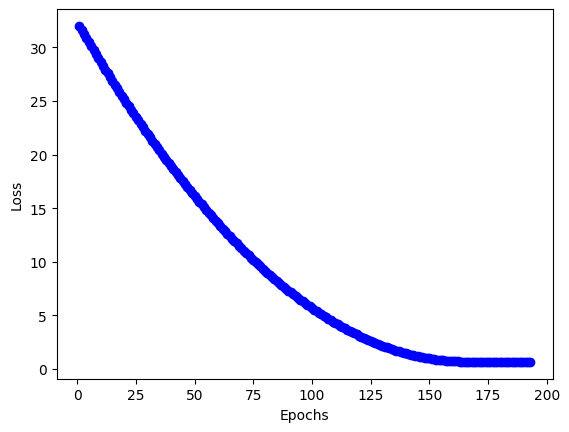

In [71]:
history_dict = history.history
loss= history_dict['loss']
val_loss = history_dict['val_loss']
plt.plot(range(1, len(loss) + 1), loss,'bo',label="Training loss")
plt.plot(range(1, len(loss) + 1), val_loss,'b',label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [72]:
results=model.evaluate(features_test, labels_test, verbose=0)
print("Test results : {results}".format(results=results))

Test results : [0.657284140586853, 0.6854047775268555]


In [73]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(features_val)
predictions[0]
predictions[1]

mse= mean_squared_error(labels_val,predictions)


print("MSE: %0.6f" % (mse))
rmse= np.sqrt(mse)
print("RMSE: %0.6f" % (rmse))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE: 0.653150
RMSE: 0.808177


In [74]:
print(predictions[0])
print(predictions[1])
labels_val=np.array(labels_val)
print(labels_val[0])
print(labels_val[1])

[5.622907]
[5.622907]
6
6


In [75]:
import pygad

desidered_output=10
def fitness_func(ga_instance,solution,solution_idx):
    input_array=np.array(solution)
    input_array_for_prediction = np.expand_dims(input_array,axis=0)
    output= model.predict(input_array_for_prediction)
    print('solution:{0} and output{1}'.format(solution, output))
    fitness = 1.0 / np.abs(output - desidered_output)
    return fitness

#sol_per_pop=100
#num_generations=1000
#num_genes=len(features_train)
#num_parents_mating=5

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = 11

init_range_low = -1
init_range_high = 10

gene_space = [np.arange(4.0, 15.0, 0.1),np.arange(0, 0.9, 0.01),np.arange(0, 1, 0.01),
              np.arange(0, 18.0, 0.1),np.arange(0.05, 0.5, 0.001),
              np.arange(2, 60, 1),np.arange(6, 160, 1),np.arange(0.800, 1.100, 0.001),np.arange(2.8, 4.0, 0.1),
              np.arange(0.10, 2.00, 0.01),np.arange(8.0, 15.0, 0.1)]

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

#ga_instance=pygad.GA(num_generations=num_generations,sol_per_pop=sol_per_pop,fitness_func=fitness_func,num_genes=num_genes,num_parents_mating=num_parents_mating,m#utation_type=None)
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=gene_space,
                       #init_range_low=init_range_low,
                       #init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
solution:[14.5    0.44   0.94  12.5    0.196 29.    89.     1.029  2.8    1.64
 12.8  ] and output[[5.622907]]


/home/niccolo/python-projects/optimization/env/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
solution:[ 5.8    0.08   0.64  11.     0.32  38.    26.     0.911  3.8    1.81
 11.1  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
solution:[10.4    0.73   0.5    7.5    0.447 48.    89.     1.014  3.6    1.52
  9.8  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
solution:[ 4.1    0.61   0.14  16.3    0.327 21.    80.     0.919  3.5    0.89
 10.2  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
solution:[  4.9     0.29    0.43    6.7     0.262   2.    157.      0.875   3.
   1.43    9.1  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
solution:[13.5    0.52   0.41  13.9    0.238 10.    27.     0.809  3.7    0.89
 13.8  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
solution:[10.4    0.67   0.23  13.     0.264 17.    51.     1.012  3.3    0.14
  8.9  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
solution:[ 11.      0.44    0.62    4.1     0.141  29.    1

/home/niccolo/python-projects/optimization/env/lib/python3.10/site-packages/pygad/utils/nsga2.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  obj_crowding_dist_list = numpy.array(obj_crowding_dist_list)
/home/niccolo/python-projects/optimization/env/lib/python3.10/site-packages/pygad/utils/nsga2.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  crowding_dist_sum = numpy.array(list(zip(obj_crowding_dist_list[0, :, 0], crowding_dist_sum)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
solution:[11.     0.44   0.62   9.4    0.32  38.    26.     0.911  3.8    1.81
 11.1  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
solution:[5.800e+00 8.000e-02 6.400e-01 7.500e+00 4.470e-01 4.800e+01 8.900e+01
 1.006e+00 3.600e+00 1.520e+00 9.800e+00] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
solution:[10.4    0.73   0.5    7.5    0.447 48.    89.     1.029  2.8    1.64
 12.1  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
solution:[14.5    0.44   0.94  12.5    0.196 29.    89.     1.029  2.8    0.69
 12.   ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
solution:[11.     0.44   0.62  11.     0.32  38.    26.     0.911  3.8    1.85
 11.1  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
solution:[5.800e+00 8.000e-02 5.000e-01 7.500e+00 3.320e-01 4.800e+01 8.900e+01
 1.014e+00 3.600e+00 1.520e+00 9.800e+00] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [76]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

input_array=np.array(solution)
input_array_for_prediction = np.expand_dims(input_array,axis=0)
    
prediction =  model.predict(input_array_for_prediction)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
solution:[14.5    0.44   0.94  12.5    0.283 54.    89.     1.029  3.6    1.64
 12.1  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
solution:[ 6.4    0.44   0.94   6.1    0.412 29.    89.     1.029  2.8    1.64
 12.8  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
solution:[14.5    0.44   0.94  12.5    0.196 29.    36.     1.029  2.8    1.11
 12.9  ] and output[[5.622907]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
solution:[ 8.3    0.84   0.94  12.5    0.283 29.    89.     1.029  3.1    1.64
 13.5  ] and output[[5.622907]]
Parameters of the best solution : [14.5    0.44   0.94  12.5    0.196 29.    89.     1.029  2.8    1.64
 12.8  ]
Fitness value of the best solution = [[0.22846214]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted output based on the best solution : [[5.622907]]
